<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import os
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
# --- DREAMER veri setini yükleme fonksiyonu ---
def load_dreamer_data(file_path):
    data = sio.loadmat(file_path)
    eeg_data = []
    labels = []
    for participant in range(23):
        for video in range(18):
            stimuli = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]
            if stimuli.size == 0:
                continue
            if stimuli.shape[0] != 14:
                stimuli = stimuli.T
            eeg_data.append(stimuli)
            valence_score = data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0]
            labels.append(valence_score)
    return eeg_data, np.array(labels)

In [134]:
# --- EEG verilerini ön işleme fonksiyonu ---
def preprocess_eeg_data(eeg_data, max_length=1000):
    padded_eeg_data = []
    for sample in eeg_data:
        if sample.shape[1] < max_length:
            padding_shape = ((0, 0), (0, max_length - sample.shape[1]))
            padded_sample = np.pad(sample, padding_shape, mode='constant', constant_values=0)
        else:
            padded_sample = sample[:, :max_length]
        padded_eeg_data.append(padded_sample)
    eeg_data = np.array(padded_eeg_data)
    scaler = StandardScaler()
    eeg_data = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data = scaler.fit_transform(eeg_data)
    eeg_data = eeg_data.reshape(-1, max_length, 14)
    return eeg_data

In [135]:
# Veri yolu
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"

In [136]:
# Veri setini yükleme
eeg_data, labels = load_dreamer_data(file_path)

In [137]:
# Veri ön işleme
eeg_data = preprocess_eeg_data(eeg_data)

In [138]:
# Etiketleri binary hale getirme
labels = LabelEncoder().fit_transform(labels > 5)  # Valence > 5 -> 1, aksi takdirde 0

In [139]:
# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.3, random_state=42)

In [140]:
# Sınıf ağırlıklarını hesaplama
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [168]:
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),  # Dropout oranını artırdık
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),  # Dropout oranını artırdık
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),  # Dropout oranını artırdık
    Dense(1, activation='sigmoid')
])

In [169]:
# --- Model Derleme ---
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Daha yüksek öğrenme oranı
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [171]:
# --- Callbacks ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [172]:
# Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4370 - loss: 3.7651 - val_accuracy: 0.5200 - val_loss: 3.0819
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4680 - loss: 3.4196 - val_accuracy: 0.6000 - val_loss: 3.0747
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4327 - loss: 3.6659 - val_accuracy: 0.6560 - val_loss: 3.0674
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4842 - loss: 3.5603 - val_accuracy: 0.6960 - val_loss: 3.0595
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5369 - loss: 3.3686 - val_accuracy: 0.7440 - val_loss: 3.0526
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4462 - loss: 3.5707 - val_accuracy: 0.7440 - val_loss: 3.0478
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4921 - loss: 3.4317 - val_accuracy: 0.7440 - val_loss: 3.0416
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5122 - loss: 3.4897 - val_accuracy: 0.7920 - val_loss:

In [173]:
# --- Test ---
test_logits = model.predict(X_test)
test_accuracy = tf.keras.metrics.BinaryAccuracy()(y_test, test_logits)
print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step
Test Accuracy: 0.9840


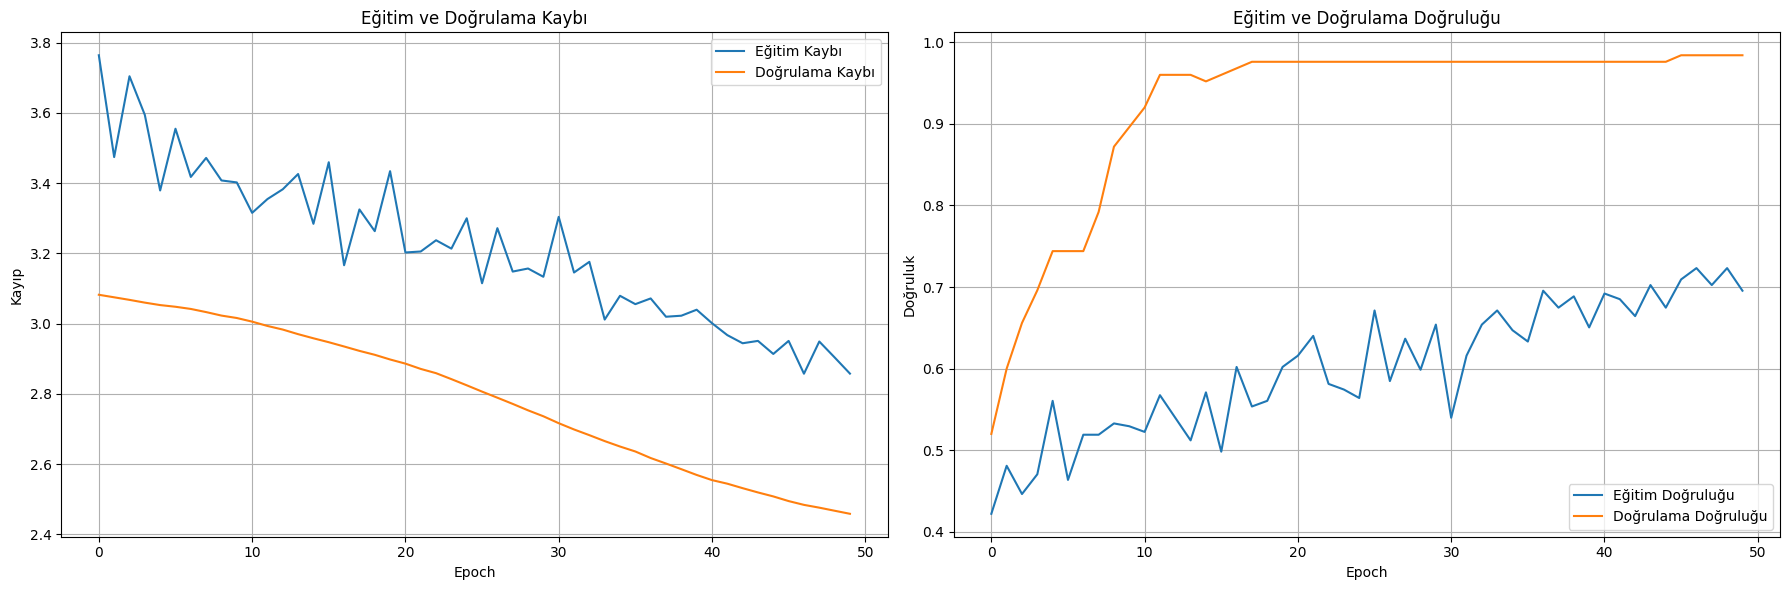

In [174]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını ve doğruluklarını yan yana çizme
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Eğitim ve Doğrulama Kaybı
axes[0].plot(history.history['loss'], label='Eğitim Kaybı')
axes[0].plot(history.history['val_loss'], label='Doğrulama Kaybı')
axes[0].set_title("Eğitim ve Doğrulama Kaybı")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Kayıp')
axes[0].legend()
axes[0].grid()

# Eğitim ve Doğrulama Doğruluğu
axes[1].plot(history.history['accuracy'], label='Eğitim Doğruluğu')
axes[1].plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
axes[1].set_title("Eğitim ve Doğrulama Doğruluğu")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Doğruluk')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()
